In [11]:
import math
import numpy as np
import cmab
import env

(200, 10)


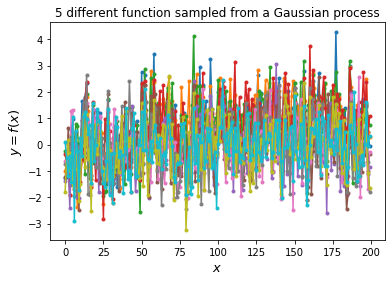

150 7.521397000616699 6.0
150 1.8821308674830344 2.0


In [12]:
p = 10 # total # of sensors
q = 4 # total # of misbehaved sensors
m = 5 # total # of observed sensors

tau = 50 # error ocurrance time
L = 200 # length of one exp episode
N = 10000 # total experiment times

# generate mu_c
delta = 1
mu = np.zeros((p, )) # normal mean
mu_c = np.zeros((p, ))
mu_c[:q] = delta # first q elements to delta, error mean
# print(mu_c)

# generate sigma
# some confusion on sigma[i,i]. set it to 1.0 here. not sure.
sigma = np.full((p, p), 0.5)
np.fill_diagonal(sigma, 1.0)

cmab.test.h = 6.0
cmab.gamma.lamda = 0.1 # lambda

Xn = env.gen_input(mu, mu_c, sigma, tau, L)
env.visualize(Xn)
detect = cmab.CMAB(p, m, L, sigma, Xn, cmab.gamma)
ADD = detect - tau
print(ADD, cmab.test.max, cmab.test.h)

cmab.CMAB_s.h = 2.0
detect = cmab.CMAB_s(p, m, L, sigma, Xn, cmab.gamma)
ADD = detect - tau
print(ADD, cmab.CMAB_s.max, cmab.CMAB_s.h)